### Importing Dependencies

In [ ]:
import os
import io
import string
from tqdm import tqdm
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np

import nltk
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Importing the dataset

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("lakshmi25npathi/imdb-dataset-of-50k-movie-reviews")

print("Path to dataset files:", path)
data = pd.read_csv(os.path.join(path, 'IMDB Dataset.csv'))






Path to dataset files: /kaggle/input/imdb-dataset-of-50k-movie-reviews


In [ ]:
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


### Convert sentiment column to int


*   For a postive review it will be represented by 1
*   For a negative review it will be represented by 0




In [ ]:
data['sentiment'] = data['sentiment'].map({'positive': 1, 'negative': 0})

# Checking for missing values

In [ ]:
print('missing values\n',data.isnull().sum())


missing values
 review       0
sentiment    0
dtype: int64


No missing values so far

# Visualizing the dataset

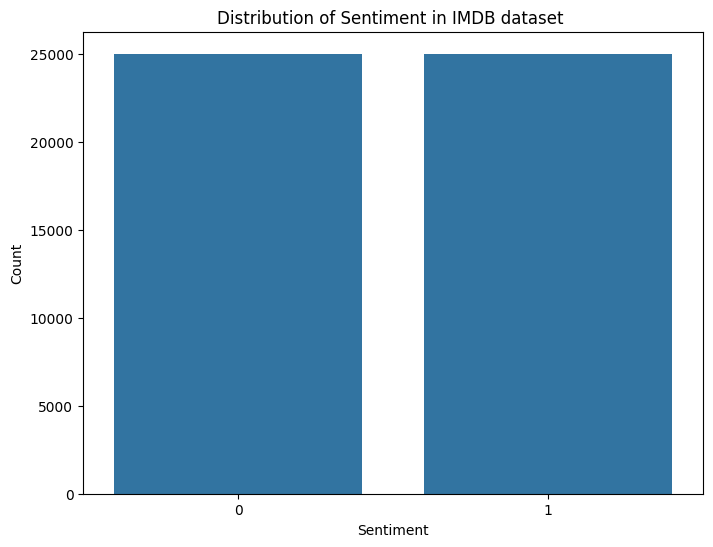

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


#plot the distribution

plt.figure(figsize=(8,6))
sns.countplot(x='sentiment',data=data)
plt.title('Distribution of Sentiment in IMDB dataset ')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

We can see that the dataset is evenly distributed with 25k in each category

### Spliting the data

Splitting the data into **train_data** and **test_data**

In [ ]:
# Shuffle the DataFrame
shuffled_data = data.sample(frac=1, random_state=2025)

train_size = 0.8  # 80% for training, 20% for testing
train_data, test_data = train_test_split(shuffled_data, train_size=train_size, random_state=2023)

In [ ]:
print(f'Train shape: {train_data.shape}')
print(f'Test shape: {test_data.shape}')

Train shape: (40000, 2)
Test shape: (10000, 2)


In [ ]:
X_train = train_data['review']
y_train = train_data['sentiment']

X_test = test_data['review']
y_test = test_data['sentiment']

## Cleaning the text data

Removing HTML tags, punctuations and stopwords




*   Downloads the stopwords list (common words like "the", "is", "and", etc.).

*  Stores them in a set for fast lookup


In [ ]:
# using stopwords from nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
table = str.maketrans('', '', string.punctuation)  #creating a mapping to remove punctuations

In [ ]:
X_train_cleaned = []

for item in tqdm(X_train):
    sentence = str(item).lower()
    # if we have 2 joined words
    sentence = sentence.replace(",", " , ")
    sentence = sentence.replace(".", " . ")
    sentence = sentence.replace("-", " - ")
    sentence = sentence.replace("/", " / ")
    # remove <br> tag
    soup = BeautifulSoup(sentence)
    sentence = soup.get_text()
    # remove stop words and punctuations
    words = sentence.split()
    filtered_sentence = ""
    for word in words:
        word = word.translate(table) # remove all punctuations
        if word not in stop_words:
            filtered_sentence += word + ' '

    X_train_cleaned.append(filtered_sentence.strip())

100%|██████████| 40000/40000 [00:21<00:00, 1844.36it/s]


### Sentence Length distribution



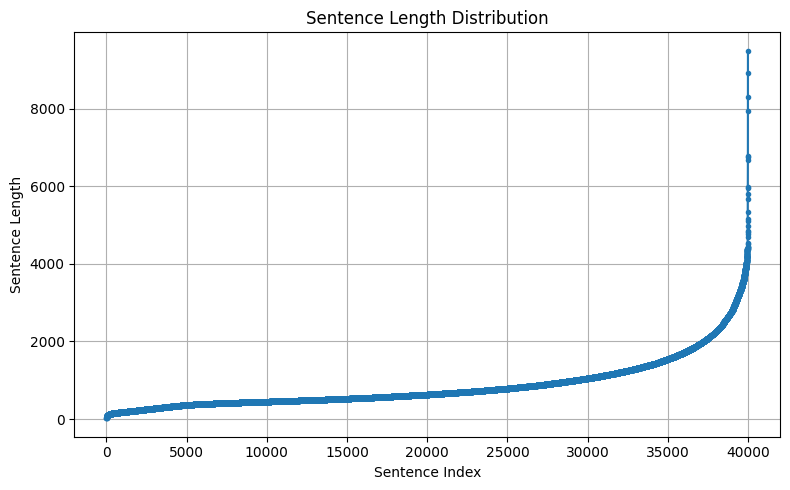

In [ ]:
sentence_lengths = [len(sentence) for sentence in X_train_cleaned]
sorted_lengths = sorted(sentence_lengths)

x_values = list(range(1, len(X_train_cleaned) + 1))


plt.figure(figsize=(8, 5))
plt.plot(x_values, sorted_lengths, marker='.', linestyle='-')
plt.title('Sentence Length Distribution')
plt.xlabel('Sentence Index')
plt.ylabel('Sentence Length')
plt.grid(True)
plt.tight_layout()
plt.show()

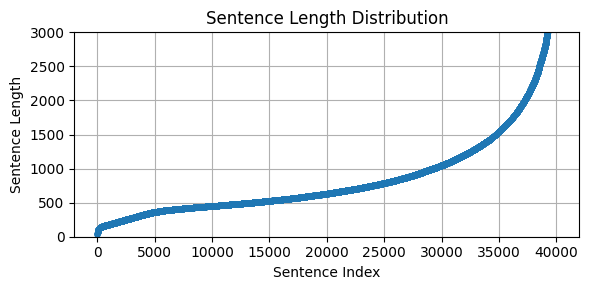

In [ ]:

plt.figure(figsize=(6, 3))
plt.plot(x_values, sorted_lengths, marker='.', linestyle='-')
plt.title('Sentence Length Distribution')
plt.xlabel('Sentence Index')
plt.ylabel('Sentence Length')
plt.grid(True)
plt.tight_layout()
plt.ylim(0, 3000)
plt.show()

**most of the sentences have less than 2000 words and 1000 words**

### Check the total set of words

In [ ]:
all_words = [word for sentence in X_train_cleaned for word in sentence.split()]

# Calculate the vocabulary size (number of unique words)
total_vocab_size = len(set(all_words))

print("Total Vocabulary Size:", total_vocab_size)

Total Vocabulary Size: 109897


### Tokenization

Tokenization, in the realm of Natural Language Processing (NLP) and machine learning, refers to the process of converting a sequence of text into smaller parts, known as tokens. These tokens can be as small as characters or as long as words. The primary reason this process matters is that it helps machines understand human language by breaking it down into bite-sized pieces, which are easier to analyze.


In [ ]:
vocab_size = 20000
max_length = 300
trunc_type='post' #the sequence will get truncated if it exceeds the max length
padding_type='post' #padding will be added
oov_tok = "<oov>" #placeholer for words out of vocabulary

In [ ]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train_cleaned) #convert the words into indices

In [ ]:
word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(X_train_cleaned)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(X_test) #converting texts into sequences
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type) #using padding

### WordCloud

A word cloud is a visual representation of text data, where the size of each word indicates its frequency or importance in a dataset. It is commonly used in Natural Language Processing (NLP) to quickly understand dominant words in a text corpus

For example, in sentiment analysis of IMDB reviews, a word cloud can help visualize the most frequent words in positive and negative reviews separately.

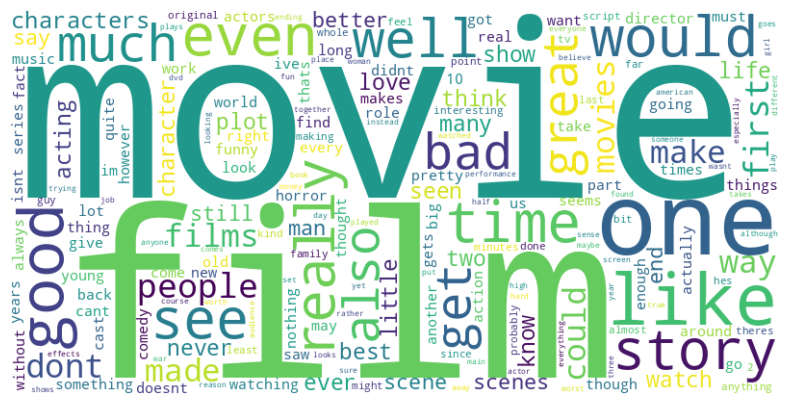

In [ ]:
wordcloud = WordCloud(width=800, height=400, background_color='white')

# Generate the word cloud
word_counts = tokenizer.word_counts
wordcloud.generate_from_frequencies(word_counts)
#wordcloud.to_file("doc/header.png")

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

plt.show()

We can see words like movie, good, better, story which highlights the fact that our data has been cleaned in a good way

### Split the train into train and validation
Using 80% for train and 20% for test

In [ ]:
training_padded, validation_padded, y_train, y_valid = train_test_split(training_padded, y_train, test_size=0.2, random_state=2023)

In [ ]:
training_padded = np.array(training_padded)
training_labels = np.array(y_train)

validation_padded = np.array(validation_padded)
validation_labels = np.array(y_valid)

testing_padded = np.array(testing_padded)
testing_labels = np.array(y_test)

In [ ]:
print(f'Train shappe: {train_data.shape}')
print(f'Validation shappe: {validation_padded.shape}')
print(f'Test shappe: {test_data.shape}')

Train shappe: (40000, 2)
Validation shappe: (8000, 300)
Test shappe: (10000, 2)


# Define the neural network




### embedding_dim:
Defines the dimensionality of the word embeddings and is set to the fourth root of vocab_size. This enables to determine an appropriate number of embedding dimensions based on vocabulary size

**Note**: embedding is a way to represent words/tokens as a vector. Instead of treating them as a isolated symbols, embeddings help capture the semantic relationships between tokens.

**eg**: Instead of treating "cat" and "dog" as completely different words, embeddings allow them to be numerically close since they have similar meaning(they are both animals)

simply put their vectors will be closer in space.



### l2_regularization:
This prevents overfitting and penalizes large weights in the neural network; Improves generalization and reduces complexity.

In [ ]:
#embedding_dim = round(vocab_size ** 0.25) # use the fourth root of the vocab size
embedding_dim = 128
l2_regularization = 0.001 # tends to amplify differences between nonzero values and zero or close-tozero ones

This function creates a simple feedforward neural network with the following layers

1. **Embedding layer**: Converts word indices into vectors and helps the model learn relationship between words

2. **Global Average pooling**: Reduces the dimensionality of embeddings by taking the average across all the words in a sentence. Results in a fixed length output vector

3. **Fully connected layer**: contains 24 neurons with ReLU as an activation function and uses L2 regularization

4. **Dropout layer**: Randomly drops 10% of the layers to reduce the chances of overfitting

5. **Output layer**: Single neuron with sigmoid activation function. Outputs the probability between 0 and 1.




We are using **Adam optimizer** with lr=0.0001 and **Binary Cross entropy** loss along with **accuracy** as an evaluation metric



In [ ]:
def create_model(vocab_size, embedding_dim):
    model = tf.keras.Sequential([
            tf.keras.layers.Embedding(vocab_size, embedding_dim), # turns positive integers into dense vectors of fixed size
            tf.keras.layers.GlobalAveragePooling1D(),
            tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_regularization)),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(32, activation='relu'),  # NEW Layer

            tf.keras.layers.Dense(1, activation='sigmoid')
        ])

    adam = tf.keras.optimizers.Adam(learning_rate=0.0005, beta_1=0.9, beta_2=0.999, amsgrad=False)

    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

    return model

In [ ]:
model = create_model(vocab_size, embedding_dim)
# Display the model's architecture
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ ?                      │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
checkpoint_path = "training/cp-{epoch:04d}.weights.h5"
checkpoint_dir = os.path.dirname(checkpoint_path)

In [ ]:
# Create a callback that saves the model's weights every 5 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1,
                                                 save_freq=5)

# Training the model

What happens during training ?

1. The model learns patterns from training_padded and training_labels

2. The accuracy and loss are reported after each epoch

3. The model's performance is checked on validation data

4. The model's weights are saved after 5 epochs

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

num_epochs = 20
class_weight = {0: 1.0, 1: 2.0}  # or try 1:1.5

history = model.fit(training_padded,
                    training_labels,
                    epochs=num_epochs,
                    validation_data=(validation_padded, validation_labels),
                    verbose=2,
                    callbacks=[cp_callback,early_stopping],
                    class_weight=class_weight)

Epoch 1/20

Epoch 1: saving model to training/cp-0001.weights.h5

Epoch 1: saving model to training/cp-0001.weights.h5

Epoch 1: saving model to training/cp-0001.weights.h5

Epoch 1: saving model to training/cp-0001.weights.h5

Epoch 1: saving model to training/cp-0001.weights.h5

Epoch 1: saving model to training/cp-0001.weights.h5

Epoch 1: saving model to training/cp-0001.weights.h5

Epoch 1: saving model to training/cp-0001.weights.h5

Epoch 1: saving model to training/cp-0001.weights.h5

Epoch 1: saving model to training/cp-0001.weights.h5

Epoch 1: saving model to training/cp-0001.weights.h5

Epoch 1: saving model to training/cp-0001.weights.h5

Epoch 1: saving model to training/cp-0001.weights.h5

Epoch 1: saving model to training/cp-0001.weights.h5

Epoch 1: saving model to training/cp-0001.weights.h5

Epoch 1: saving model to training/cp-0001.weights.h5

Epoch 1: saving model to training/cp-0001.weights.h5

Epoch 1: saving model to training/cp-0001.weights.h5

Epoch 1: saving 

### Save the entire model

In [ ]:
model.save('model/sentiment_model_v1.h5')

# Plotting accuracy and Loss

In [ ]:
def plot_history(history, name):
  plt.plot(history.history[name])
  plt.plot(history.history['val_'+name])
  plt.xlabel("Epochs")
  plt.ylabel(name)
  plt.legend([name, 'val_'+name])
  plt.show()

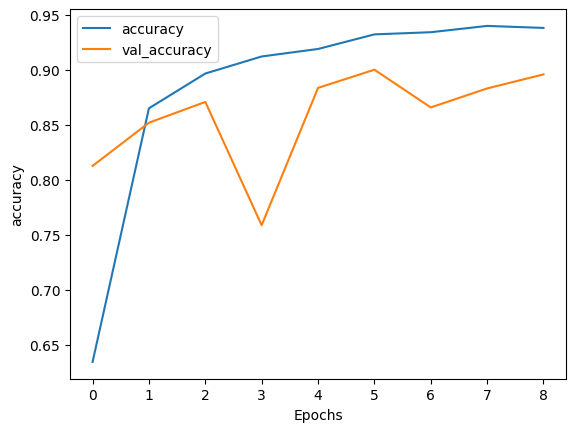

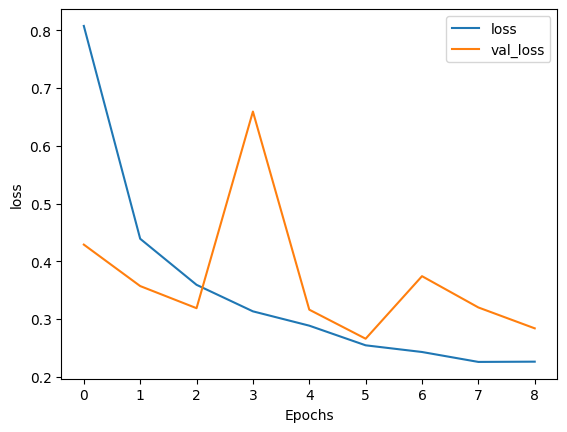

In [ ]:
plot_history(history, "accuracy")
plot_history(history, "loss")

### Evaluate the model

In [ ]:
model.evaluate(testing_padded, testing_labels, verbose=2)

313/313 - 2s - 6ms/step - accuracy: 0.8422 - loss: 0.4265


[0.42652592062950134, 0.842199981212616]

In [ ]:
from sklearn.metrics import f1_score, classification_report

# Step 1: Predict on test set
pred_probs = model.predict(testing_padded)

# Step 2: Convert to binary class labels
pred_labels = (pred_probs > 0.5).astype(int).flatten()

# Step 3: Evaluate
f1 = f1_score(testing_labels, pred_labels)
print(f"F1 Score: {f1}")

# Optional: Full classification report
print(classification_report(testing_labels, pred_labels))


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
F1 Score: 0.8206818181818182
              precision    recall  f1-score   support

           0       0.78      0.96      0.86      4996
           1       0.95      0.72      0.82      5004

    accuracy                           0.84     10000
   macro avg       0.86      0.84      0.84     10000
weighted avg       0.86      0.84      0.84     10000



### Make predictions

In [ ]:
sentences = ["I recently watched it, and it's absolutely fantastic. The acting, direction, and storytelling are all top-notch. I highly recommend it.",
             "I watched it and was let down. The acting felt flat, and the story was uninspiring. I wouldn't recommend it.",
             "The movie was very bad and a waste of time ",
              "Loved every bit of the movie "]
sequences = tokenizer.texts_to_sequences(sentences)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(model.predict(padded))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
[[0.9213986 ]
 [0.19132948]
 [0.04459222]
 [0.7739164 ]]
